**PREDICCIÓN DE LOS INGRESOS**

***MARÍA CAMILA VILLAMIZAR VILLAMIZAR & CARLOS FERNANDO ESCOBAR SILVA***

*INSTALAR E IMPORTAR LAS LIBRERIAS*

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install -U scikit-learn
!pip install imblearn
!pip install --upgrade scikit-learn imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, requests, zipfile, io
from scipy.io import arff

#importo el modelo de naive_bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

#importo métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc

#importo librerías de validación cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

#ajuste de datos
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import ipywidgets as widgets

#árboles
from sklearn import tree
from sklearn.tree import plot_tree

#Bosques
from sklearn.ensemble import RandomForestClassifier

#.bin
import joblib as jb

#gradientClassifier
from sklearn.ensemble import GradientBoostingClassifier

#xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [3]:
warnings.simplefilter('ignore')

*DEFINIR LA URL/DESCARGAR Y EXTRAER EL CONTENIDO*

In [4]:
f_zip = 'https://github.com/adiacla/bigdata/raw/master/adult.csv.zip'
r = requests.get(f_zip, stream=True)
zip_file = zipfile.ZipFile(io.BytesIO(r.content))
zip_file.extractall()

*LEER EL CSV Y CREAR EL DATAFRAME*

In [5]:
with zip_file.open('adult.csv') as csv_file:
    df = pd.read_csv(csv_file)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


*VERIFICAR EL TAMAÑO Y LOS TIPOS DE DATOS DEL DATAFRAME*

In [6]:
df.shape

(32561, 15)

In [7]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [8]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

*HACER EL PREPROCESAMIENTO DE DATOS*

In [9]:
#VERIFICAR SI HAY DATOS FALTANTES
missing_data = df.isnull().sum()
print(missing_data)

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [10]:
registros_con_nan = df.isna().sum()
print(registros_con_nan)

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [11]:
# Convertir todas las celdas del DataFrame a cadenas de texto y luego buscar valores que consistan solo en espacios en blanco
valores_con_espacios = (df.astype(str).applymap(str.isspace)).sum().sum()
print("Número total de valores que consisten solo en espacios en blanco:", valores_con_espacios)

Número total de valores que consisten solo en espacios en blanco: 0


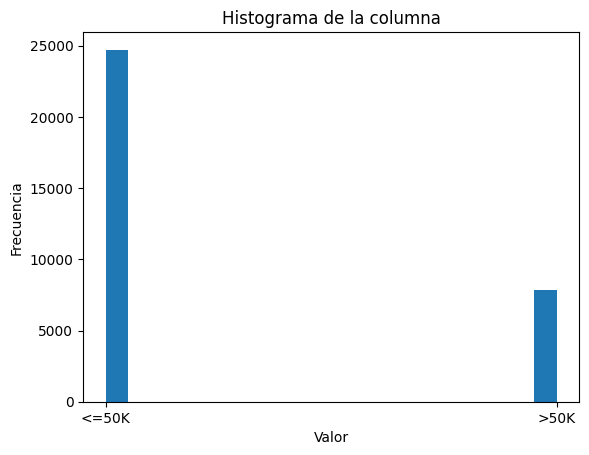

In [12]:
#Crear un histograma de la columna 'income' del DataFrame df, omitiendo los valores NaN, con 20 contenedores, 
#  y etiquetas adecuadas para los ejes x e y, así como un título para el gráfico.
plt.hist(df['income'].dropna(), bins=20)  # Omitir NaN en la visualización
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de la columna')
plt.show()

In [13]:
valores_nan_por_columna = df.isna().any()

#Mostrar los nombres de las columnas que contienen NaN
print(valores_nan_por_columna)

age               False
workclass         False
fnlwgt            False
education         False
education.num     False
marital.status    False
occupation        False
relationship      False
race              False
sex               False
capital.gain      False
capital.loss      False
hours.per.week    False
native.country    False
income            False
dtype: bool


*ELIMINAR LAS FILAS CON '?'*

In [14]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA WORKCLASS
unique_values = df['workclass'].unique()

print(unique_values)

['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']


In [15]:
count_question_marks = df['workclass'].value_counts()['?']
print (count_question_marks)

1836


In [16]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA OCCUPATION
unique_values = df['occupation'].unique()

print(unique_values)

count_question_marks = df['occupation'].value_counts()['?']
print (count_question_marks)

['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
1843


In [17]:
#Buscar los signos '?' que comparten la columna workclass y occupation
filas_quotemark = df.loc[(df['workclass'] == '?') & (df['occupation'] == '?')]

num_filas_quotemark = len(filas_quotemark)
print(num_filas_quotemark)

1836


In [18]:
#Eliminar las filas con '?'
df.drop(filas_quotemark.index, inplace=True)

In [19]:
#Calcular la moda de la columna "occupation" excluyendo los valores de signo de pregunta
moda_occupation = df[df['occupation'] != '?']['occupation'].mode()[0]
print(moda_occupation)

#Imputar la moda a los valores de signo de pregunta en la columna "occupation"
df['occupation'] = df['occupation'].replace('?', moda_occupation)

Prof-specialty


In [20]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


In [21]:
# Definir el orden de los niveles de workclass
order_workclass = {
    'Private': 1,
    'State-gov': 2,
    'Federal-gov': 3,
    'Self-emp-not-inc': 4,
    'Self-emp-inc':5,
    'Local-gov': 6,
    'Without-pay':7,
    'Never-worked':8,
    'Other':9,
    'Undefined':0
}

# Guardar los datos de la columna 'workclass' en un diccionario usando el mapeo específico
data_workclass_dict = {'workclass': df['workclass'].map(order_workclass)}
# Reemplazar los valores en la columna 'workclass' del DataFrame con los valores del diccionario
df['workclass'] = df['workclass'].map(order_workclass)

In [22]:
df['workclass'] = df['workclass'].fillna(0)

In [23]:
print(df['workclass'].unique())

[1 2 3 4 5 6 7 8]


In [24]:
nan_rows = df[df['workclass'].astype(str).str.contains('0.')]

# Imprimir las filas que contienen la cadena '0.'
print(nan_rows)
print(len(nan_rows))

Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education.num, marital.status, occupation, relationship, race, sex, capital.gain, capital.loss, hours.per.week, native.country, income]
Index: []
0


In [25]:
# Reemplazar la cadena '0.' con '0' en las filas seleccionadas
nan_rows['workclass'] = nan_rows['workclass'].astype(str)
nan_rows['workclass'] = nan_rows['workclass'].str.replace('0.', '0')

# Mostrar las filas actualizadas
print("Filas actualizadas:")
print(nan_rows)

Filas actualizadas:
Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education.num, marital.status, occupation, relationship, race, sex, capital.gain, capital.loss, hours.per.week, native.country, income]
Index: []


In [26]:
#cambiar el tipo de dato a entero
df['workclass']=df['workclass'].astype('int')

In [27]:
# Definir el orden de los niveles de occupation
order_occupation = {
    'Exec-managerial': 1,
    'Machine-op-inspct': 2,
    'Prof-specialty': 3,
    'Other-service': 4,
    'Adm-clerical':5,
    'Craft-repair': 6,
    'Transport-moving':7,
    'Handlers-cleaners':8,
    'Sales':9,
    'Farming-fishing':10,
    'Tech-support':11,
    'Protective-serv':12,
    'Armed-Forces':13,
    'Priv-house-serv':14
}

# Guardar los datos de la columna 'occupation' en un diccionario usando el mapeo específico
data_occupation_dict = {'occupation': df['occupation'].map(order_occupation)}

# Reemplazar los valores en la columna 'occupation' del DataFrame con los valores del diccionario
df['occupation'] = df['occupation'].map(order_occupation)

*ELIMINAR UNA DE LAS COLUMNAS DE EDUCACIÓN (DADO QUE SON REDUNDANTES)*

In [28]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA EDUCATION
unique_values = df['education'].unique()

print(unique_values)

['HS-grad' '7th-8th' 'Some-college' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']


In [29]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA EDUCATION.NUM
unique_values = df['education.num'].unique()
print(unique_values)

[ 9  4 10  6 16 15 13 14  7 12 11  2  3  8  5  1]


In [30]:
# Definir el orden de los niveles de educación
order_education = {
    'Preschool': 1,
    '1st-4th': 2,
    '5th-6th': 3,
    '7th-8th': 4,
    '9th': 5,
    '10th': 6,
    '11th': 7,
    '12th': 8,
    'HS-grad': 9,
    'Some-college': 10,
    'Assoc-voc': 11,
    'Assoc-acdm': 12,
    'Bachelors': 13,
    'Masters': 14,
    'Prof-school': 15,
    'Doctorate': 16
}

# Guardar los datos de la columna 'education' en un diccionario usando el mapeo específico
data_education_dict = {'education': df['education'].map(order_education)}

In [31]:
# Eliminar la columna 'education' del DataFrame
df.drop('education', axis=1, inplace=True)

*VERIFICAR LOS DATOS DE CADA FEATURE*

In [32]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA marital.status
unique_values = df['marital.status'].unique()
print(unique_values)

['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']


In [33]:
# Definir el orden de los niveles de marital.status
order_marital_status = {
    'Undefined' : 0,
    'Widowed': 1,
    'Divorced': 2,
    'Separated': 3,
    'Never-married': 4,
    'Married-civ-spouse': 5,
    'Married-spouse-absent': 6,
    'Married-AF-spouse': 7
}

# Guardar los datos de la columna 'marital.status' en un diccionario usando el mapeo específico
data_marital_status_dict = {'marital.status': df['marital.status'].map(order_marital_status)}

# Reemplazar los valores en la columna 'marital.status' del DataFrame con los valores del diccionario
df['marital.status'] = df['marital.status'].map(order_marital_status)

In [34]:
df['marital.status'] = df['marital.status'].fillna(0)

In [35]:
print(df['marital.status'].unique())

[1 2 3 4 5 6 7]


In [36]:
#cambiar el tipo de dato a entero
df['marital.status']=df['marital.status'].astype('int')

In [37]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA relationship
unique_values = df['relationship'].unique()
print(unique_values)

['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']


In [38]:
# Definir el orden de los niveles de relationship
order_relationship = {
    'Not-in-family': 1,
    'Unmarried': 2,
    'Own-child': 3,
    'Other-relative': 4,
    'Husband':5,
    'Wife': 6
}

# Guardar los datos de la columna 'relationship' en un diccionario usando el mapeo específico
data_relationship_dict = {'relationship': df['relationship'].map(order_relationship)}

# Reemplazar los valores en la columna 'relationship' del DataFrame con los valores del diccionario
df['relationship'] = df['relationship'].map(order_relationship)

In [39]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA race
unique_values = df['race'].unique()
print(unique_values)

['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']


In [40]:
# Definir el orden de los niveles de race
order_race = {
    'Amer-Indian-Eskimo': 1,
    'Other': 2,
    'Asian-Pac-Islander': 3,
    'Black': 4,
    'White':5,
}

# Guardar los datos de la columna 'race' en un diccionario usando el mapeo específico
data_race_dict = {'race': df['race'].map(order_race)}

# Reemplazar los valores en la columna 'race' del DataFrame con los valores del diccionario
df['race'] = df['race'].map(order_race)

In [41]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA sex
unique_values = df['sex'].unique()
print(unique_values)

['Female' 'Male']


In [42]:
# Convierte los valores de bytes a cadenas
df['sex'] = df['sex'].astype(str)

# Realiza la sustitución
df.loc[df['sex'] == "Female", ['sex']] = 0
df.loc[df['sex'] == "Male", ['sex']] = 1

In [43]:
df['sex']=df['sex'].astype('int')

*CREA EL TAG 'OTHER' PARA REEMPLAZAR LOS DATOS '?' EN NATIVE.COUNTRY*

In [44]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA native.country
unique_values = df['native.country'].unique()
print(unique_values)

['United-States' '?' 'Mexico' 'Greece' 'Vietnam' 'China' 'Taiwan' 'India'
 'Philippines' 'Trinadad&Tobago' 'Canada' 'South' 'Holand-Netherlands'
 'Puerto-Rico' 'Poland' 'Iran' 'England' 'Germany' 'Italy' 'Japan' 'Hong'
 'Honduras' 'Cuba' 'Ireland' 'Cambodia' 'Peru' 'Nicaragua'
 'Dominican-Republic' 'Haiti' 'Hungary' 'Columbia' 'Guatemala'
 'El-Salvador' 'Jamaica' 'Ecuador' 'France' 'Yugoslavia' 'Portugal' 'Laos'
 'Thailand' 'Outlying-US(Guam-USVI-etc)' 'Scotland']


In [45]:
count_question_marks = df['native.country'].value_counts()['?']
print (count_question_marks)

556


In [46]:
#Imputar los valores de signo de pregunta en la columna "native.country"
df['native.country'] = df['native.country'].replace('?', 'Other')

In [47]:
# Definir el orden de los niveles de native.country
order_native_country = {
    'United-States':1, 
    'Mexico':2, 
    'Greece':3, 
    'Vietnam':4,
    'China':5, 
    'Taiwan':6,
    'India':7,
    'Philippines':8, 
    'Trinadad&Tobago':9,
    'Canada':10,
    'South':11,
    'Holand-Netherlands':12,
    'Puerto-Rico':13,
    'Poland':14,
    'Iran':15, 
    'England':16,
    'Germany':17,
    'Italy':18,
    'Japan':19,
    'Hong':20,
    'Honduras':21,
    'Cuba':22,
    'Ireland':23,
    'Cambodia':24,
    'Peru':25, 
    'Nicaragua':26,
    'Dominican-Republic':27,
    'Haiti':28, 
    'Hungary':29,
    'Columbia':30,
    'Guatemala':31,
    'El-Salvador':32,
    'Jamaica':33,
    'Ecuador':34,
    'France':35,
    'Yugoslavia':36,
    'Portugal':37,
    'Laos':38,
    'Thailand':39,
    'Outlying-US(Guam-USVI-etc)':40,
    'Scotland':41,
    'Other':42
}

# Guardar los datos de la columna 'native.country' en un diccionario usando el mapeo específico
data_native_country_dict = {'native.country': df['native.country'].map(order_native_country)}

# Reemplazar los valores en la columna 'native.country' del DataFrame con los valores del diccionario
df['native.country'] = df['native.country'].map(order_native_country)

In [48]:
df['native.country'] = df['native.country'].fillna(42)

In [49]:
#OBTENER LOS DATOS ÚNICOS DE LA COLUMNA native.country
unique_values = df['native.country'].unique()
print(unique_values)

[ 1 42  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


In [50]:
# Reemplazar la cadena '0.' con '0' en las filas seleccionadas
nan_rows['native.country'] = nan_rows['native.country'].astype(str)
nan_rows['native.country'] = nan_rows['native.country'].str.replace('42.', '42')

# Mostrar las filas actualizadas
print("Filas actualizadas:")
print(nan_rows)

Filas actualizadas:
Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education.num, marital.status, occupation, relationship, race, sex, capital.gain, capital.loss, hours.per.week, native.country, income]
Index: []


In [51]:
#cambiar el tipo de dato a entero
df['native.country']=df['native.country'].astype('int')

In [52]:
df['income'].value_counts()

income
<=50K    23075
>50K      7650
Name: count, dtype: int64

*CAMBIAR EL TIPO DE DATO DEL LABEL A ENTERO*

In [53]:
# Convierte los valores de bytes a cadenas
df['income'] = df['income'].astype(str)

# Realiza la sustitución
df.loc[df['income'] == "<=50K", ['income']] = 0
df.loc[df['income'] == ">50K", ['income']] = 1


In [54]:
df['income']=df['income'].astype('int')

In [55]:
df.dtypes

age               int64
workclass         int64
fnlwgt            int64
education.num     int64
marital.status    int64
occupation        int64
relationship      int64
race              int64
sex               int64
capital.gain      int64
capital.loss      int64
hours.per.week    int64
native.country    int64
income            int64
dtype: object

In [56]:
df.reset_index(drop=True, inplace=True)

*CREAR ARREGLOS PARA LAS FEATURES*

In [57]:
features=['age','workclass','fnlwgt','education.num','marital.status','occupation',
          'relationship','race','sex','capital.gain','capital.loss','hours.per.week','native.country','income']

*VERIFICAR LA DENSIDAD DE LOS DATOS Y LOS POSIBLES OUTLIERS*

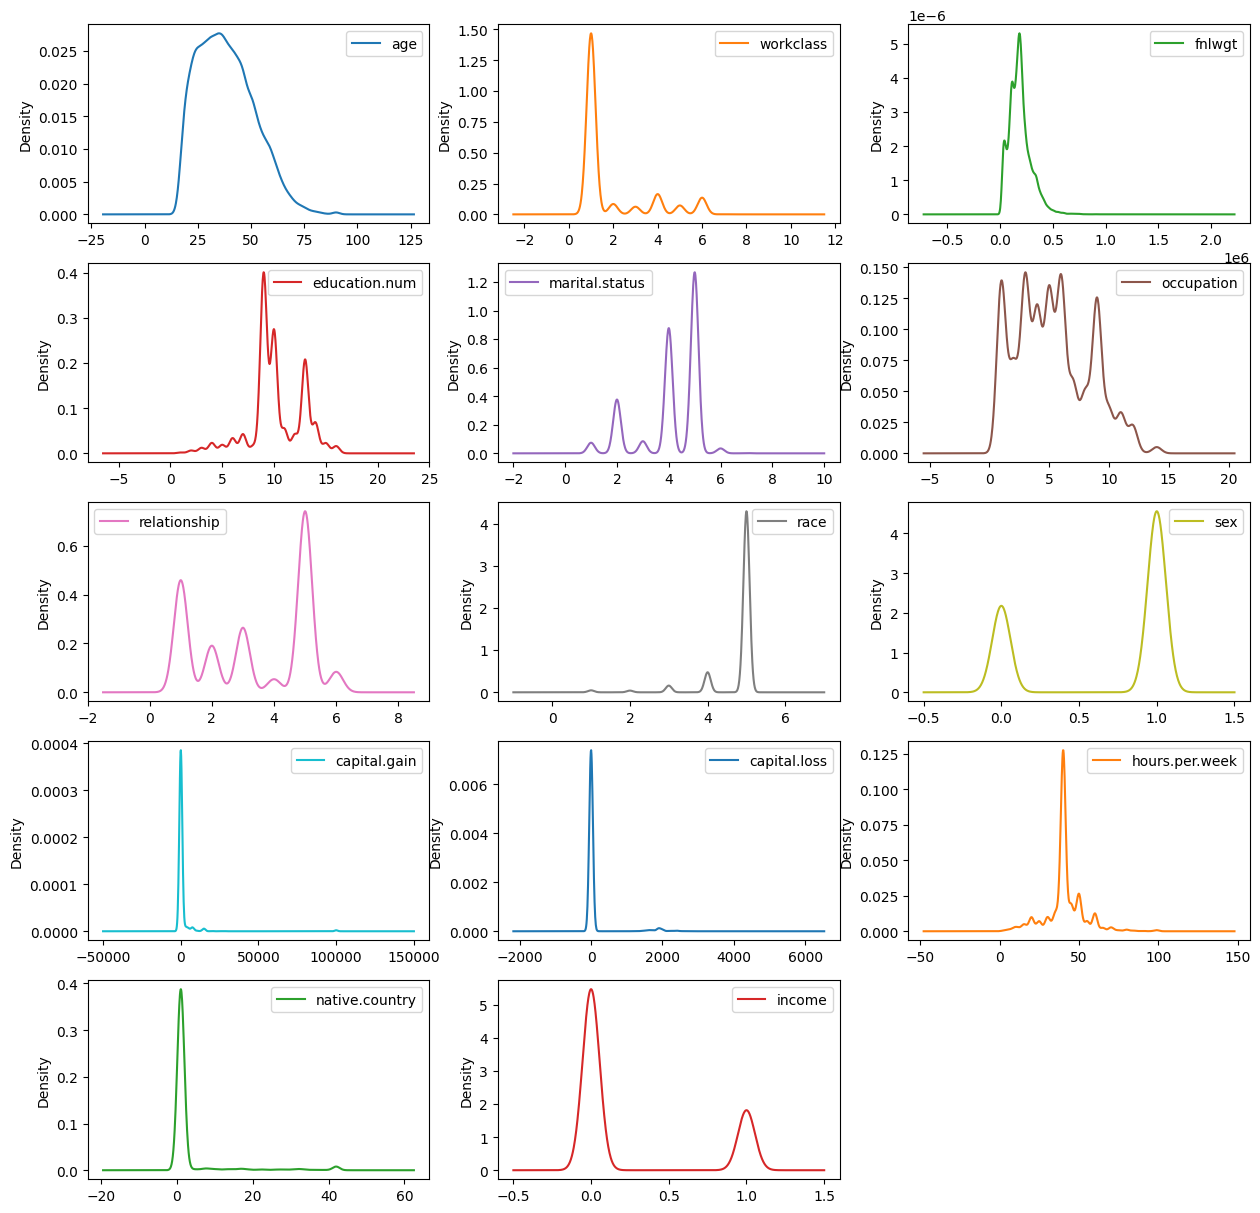

In [58]:
df.plot(kind='density',subplots=True,layout=(5,3),figsize=(15,15),sharex=False)
plt.show()

Respecto a la densidad de los datos, se puede concluír de manera preliminar, teniendo en cuenta la naturaleza de los mismos, que se tiene un sesgo al crear los diversos modelos, dado que la mayoría de la población tiene las siguientes características: hombres, blancos y estadounidenses. 

<Axes: >

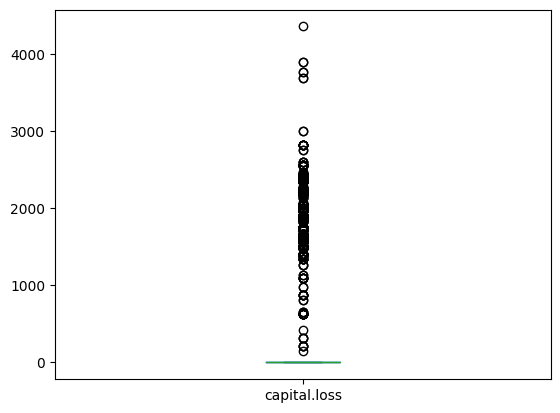

In [59]:
df['capital.loss'].plot.box()

*ELIMINAR LOS OUTLIERS DE CAPITAL.GAIN*

In [60]:
index_9= df.index[df['capital.gain'].eq(99999)]
print(index_9)

Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
       ...
       1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615],
      dtype='int64', length=155)


In [61]:
df = df[df['capital.gain'] != 99999]

<Axes: >

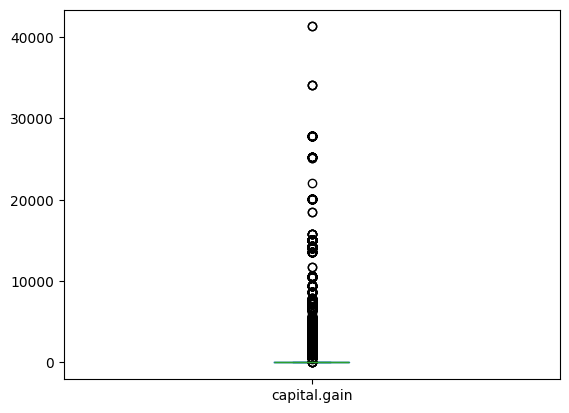

In [62]:
df['capital.gain'].plot.box()

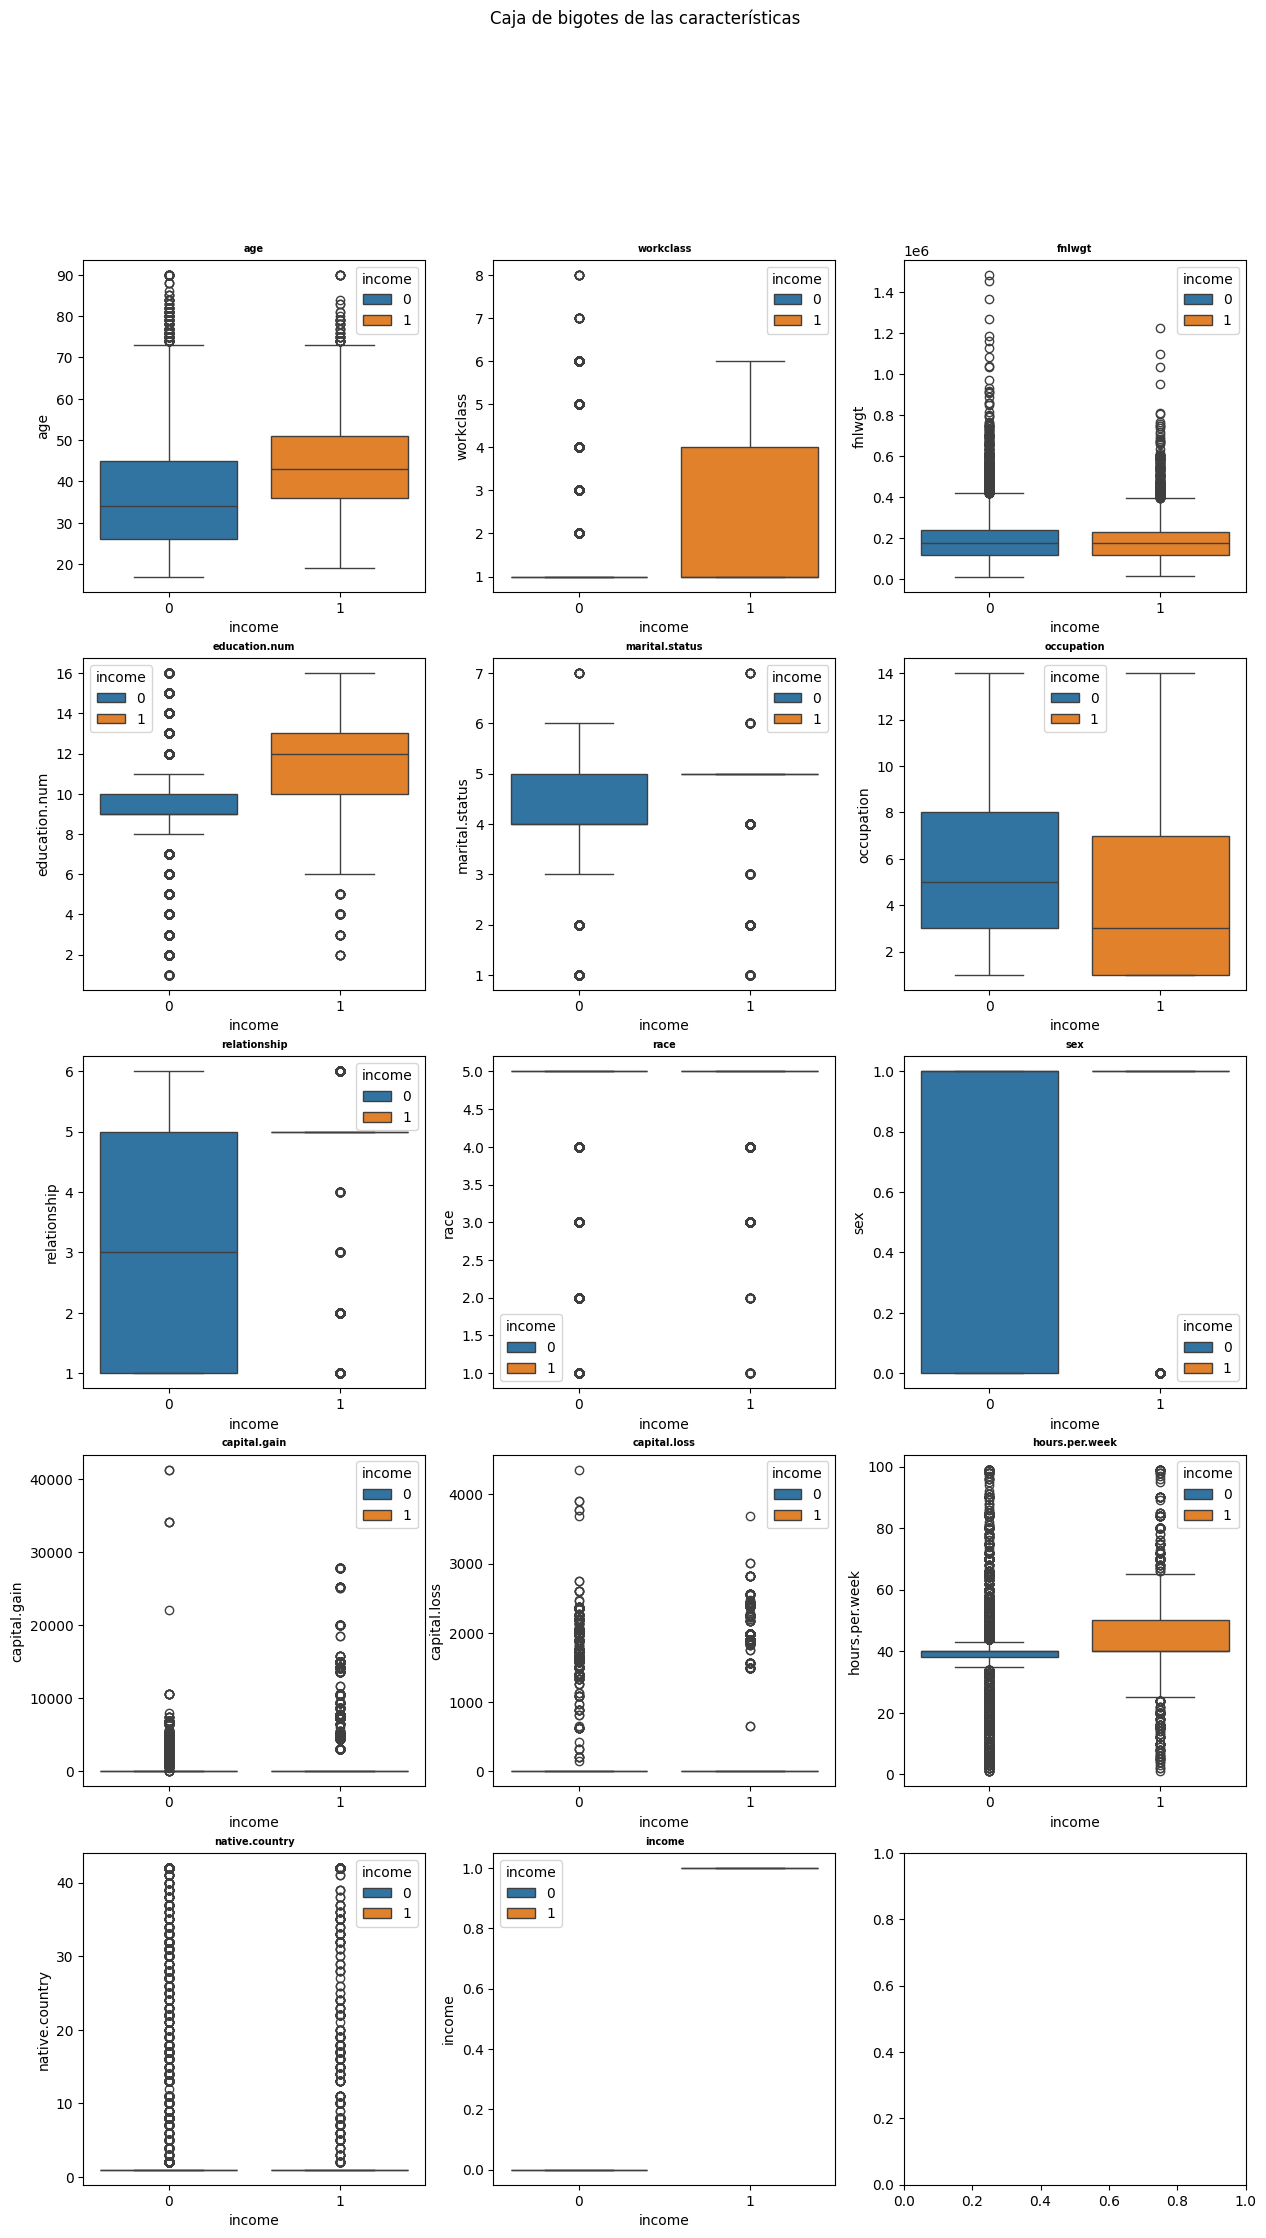

In [63]:
fig, axes = plt.subplots(5, 3, figsize=(15, 25))
axes = axes.flat[:len(features)]  # Limita el tamaño de axes

# Ajusta el rango del bucle para evitar índices fuera de los límites
for i, columnas in enumerate(features[:len(axes)]):
    sns.boxplot(x='income', y=columnas, data=df, hue='income', ax=axes[i])
    axes[i].set_title(columnas, fontsize=7, fontweight='bold')

fig.suptitle('Caja de bigotes de las características')
plt.show()

Basándonos en el análisis de los datos proporcionados, observamos que en la mayoría de las columnas del conjunto de datos hay una gran concentración de datos en unas pocas características, lo que sugiere la predominancia de ciertas categorías. Por ejemplo, la mayoría de las personas que ganan menos de 50k provienen del sector privado en términos de empleo, mientras que aquellos que ganan más de 50k tienden a tener niveles de educación más altos, como asociados vocacionales, académicos o licenciados. Además, se destaca que la mayoría de las personas que ganan más de 50k tienen estado civil de esposo, lo que puede indicar una posible correlación entre el estado civil y el nivel de ingresos. Esto sumado al sesgo que mencionabamos anteriormente sobre la naturaleza de los datos en la que priman las siguientes características: (hombres, blancos, estadounidenses).

*CREAR UNA MATRIZ DE CORRELACIÓN PARA VERIFICAR SÍ HAY COLINEALIDAD EN LAS VARIABLES*

In [64]:
#Calcular la matriz de correlación solo para los features seleccionados
matriz_correlacion = df[features].corr()
matriz_correlacion

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
age,1.000000,0.198338,-0.076793,0.040437,-0.054622,-0.066128,0.176438,0.033177,0.081036,0.119572,0.061282,0.101251,0.001670,0.239789
workclass,0.198338,1.000000,-0.039415,0.140691,0.041037,-0.000581,0.091967,0.008607,0.056203,0.048184,0.038860,0.099576,-0.020711,0.110046
fnlwgt,-0.076793,-0.039415,1.000000,-0.043912,0.002759,0.016403,-0.022243,0.007852,0.026478,-0.005061,-0.010026,-0.023626,0.032516,-0.009789
education.num,0.040437,0.140691,-0.043912,1.000000,0.063776,-0.201975,0.023618,0.037379,0.004469,0.146581,0.081044,0.146969,-0.029879,0.329240
marital.status,-0.054622,0.041037,0.002759,0.063776,1.000000,0.017338,0.709765,0.024074,0.412088,0.061374,0.051016,0.122620,0.029345,0.297245
occupation,-0.066128,-0.000581,0.016403,-0.201975,0.017338,1.000000,-0.000449,0.008014,0.087301,-0.059979,-0.030724,-0.028438,-0.020511,-0.123291
relationship,0.176438,0.091967,-0.022243,0.023618,0.709765,-0.000449,1.000000,0.042680,0.347264,0.080310,0.064498,0.117371,0.001915,0.381298
race,0.033177,0.008607,0.007852,0.037379,0.024074,0.008014,0.042680,1.000000,0.064358,0.019613,0.019746,0.034051,-0.151755,0.066848
sex,0.081036,0.056203,0.026478,0.004469,0.412088,0.087301,0.347264,0.064358,1.000000,0.063712,0.047522,0.228647,-0.004564,0.215203
capital.gain,0.119572,0.048184,-0.005061,0.146581,0.061374,-0.059979,0.080310,0.019613,0.063712,1.000000,-0.051498,0.084165,-0.008456,0.310510


<Axes: >

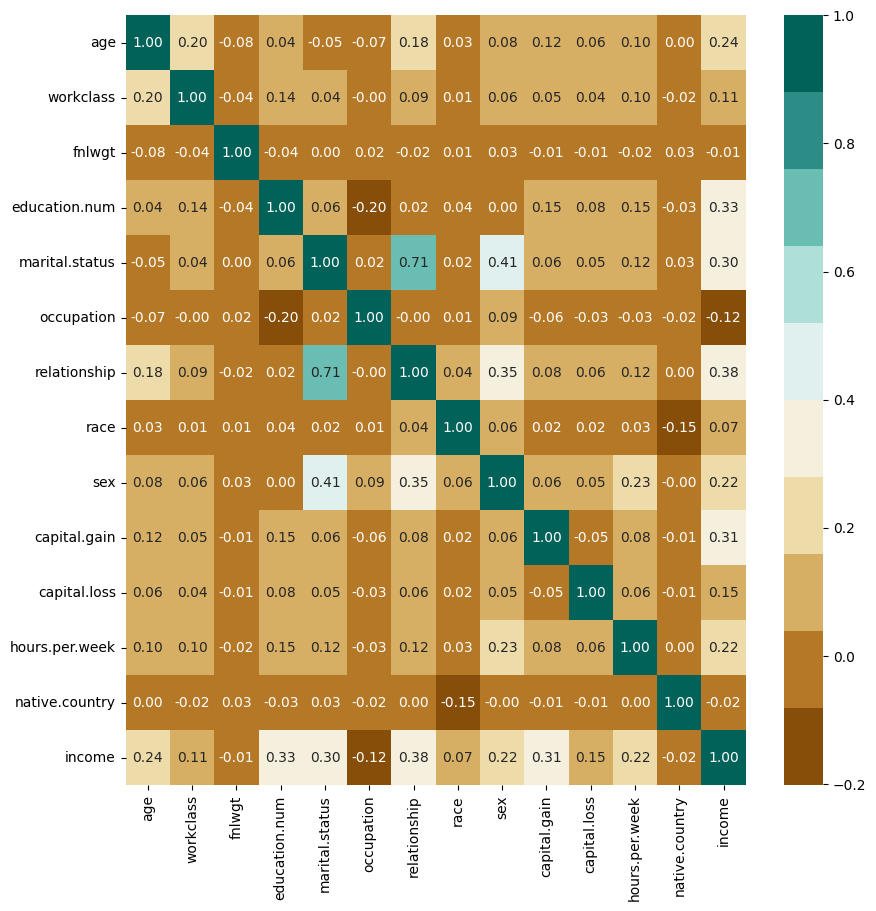

In [65]:
fig, axis=plt.subplots(figsize=(10,10))
colormap=sns.color_palette("BrBG",10)
sns.heatmap(matriz_correlacion, cmap=colormap, annot=True, fmt=".2f")

Se puede concluír que no hay una colinealidad suficientemente alta entre las variables al punto de decidir eliminarlas

*SEPARAR LOS DATOS DE TESTING Y DE TRAINING*

In [66]:
X=df.drop("income",axis=1)
y=df["income"]

In [67]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=454,stratify=df['income'])

In [68]:
y_train.value_counts()

income
0    18460
1     5996
Name: count, dtype: int64

In [69]:
y_test.value_counts()

income
0    4615
1    1499
Name: count, dtype: int64

In [70]:
len(X_train),(X_test)

(24456,
        age  workclass  fnlwgt  education.num  marital.status  occupation  \
 8621    41          1  140590             10               4           9   
 2156    66          5  197816             13               5           1   
 28784   42          1  168515             11               2           3   
 2328    27          4   37302             12               5           7   
 16524   25          4  463667              9               4           4   
 ...    ...        ...     ...            ...             ...         ...   
 9209    21          1  223811             11               4           1   
 5472    28          1  215873              6               4           2   
 28915   17          1  128617              6               4           8   
 3248    31          1  369825             13               4           9   
 30612   35          1  102268             13               5           1   
 
        relationship  race  sex  capital.gain  capital.loss  hours

In [71]:
#Restablecer los índices de X_train_final y y_train para que coincidan
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

*APLICAMOS EL SMOTE PARA IGUALAR LA CANTIDAD DE DATOS*

36920
income
0    18460
1    18460
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

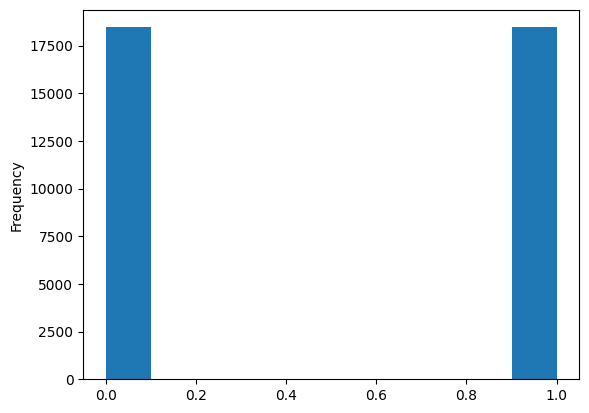

In [72]:
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample (X_train, y_train)

print(len(y_resampled))
print(y_resampled.value_counts())
y_resampled.plot.hist()

*MODELO NAIVE BAYES CON LOS DATOS AJUSTADOS*

In [73]:
# Se crea un modelo de clasificación utilizando el algoritmo Naive Bayes Gaussiano
# utilizando la implementación proporcionada por scikit-learn.
modeloNB = GaussianNB()

In [74]:
# Se ajusta el modelo de clasificación creado previamente (modeloNB) utilizando los datos de entrada (X_resampled)
# y los correspondientes valores objetivo (y_resampled) mediante el método fit.
modeloNB.fit(X_resampled, y_resampled)

GaussianNB()

In [75]:
# Se guarda el modelo de clasificación (modeloNB) en un archivo binario utilizando la biblioteca joblib.
# El archivo se nombra "modeloNB.bin" y se comprime para reducir el tamaño del archivo.
jb.dump(modeloNB, "modeloNB.bin", compress=True)

['modeloNB.bin']

In [76]:
# Se utiliza el modelo de clasificación (modeloNB) para realizar predicciones sobre los datos de prueba (X_test)
# utilizando el método predict.
y_predict = modeloNB.predict(X_test)

In [77]:
# Se crea un DataFrame llamado y_predictdf que contiene las predicciones realizadas por el modelo (y_predict),
# con una sola columna llamada "prediccion".
y_predictdf = pd.DataFrame(y_predict, columns=["prediccion"])

In [78]:
# Se reindexa el DataFrame y_test para asegurarse de que los índices estén en orden,
# utilizando el método reset_index con el argumento drop=True para eliminar los índices anteriores.
y_test_ordenado = y_test.reset_index(drop=True)

In [79]:
# Se crea un DataFrame llamado comparativo que contiene las etiquetas reales (y_test_ordenado)
# y las predicciones realizadas por el modelo (y_predictdf), concatenándolos a lo largo del eje de las columnas (axis=1).
comparativo = pd.concat([y_test_ordenado, y_predictdf], axis=1)
print(comparativo.head(20))

    income  prediccion
0        0           0
1        1           1
2        0           0
3        1           1
4        0           0
5        0           0
6        1           0
7        0           0
8        0           0
9        0           0
10       0           0
11       0           1
12       0           0
13       1           1
14       0           1
15       0           0
16       1           1
17       0           0
18       0           1
19       0           0


In [80]:
# Se calcula el puntaje de precisión del modelo de clasificación (modeloNB) utilizando los datos de prueba (X_test, y_test),
# utilizando el método score.
puntaje_precision = modeloNB.score(X_test, y_test)

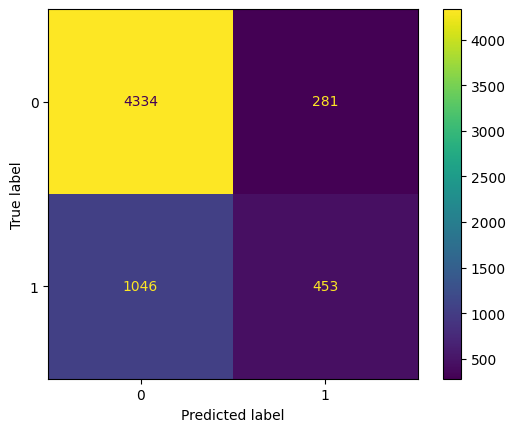

In [81]:
# Se calcula la matriz de confusión utilizando las etiquetas reales (y_test) y las predicciones del modelo (y_predict),
# utilizando la función confusion_matrix de scikit-learn.
matrix = confusion_matrix(y_test, y_predict)

# Se crea una visualización de la matriz de confusión utilizando la clase ConfusionMatrixDisplay de scikit-learn,
# especificando la matriz de confusión y las etiquetas de clase del modelo (modeloNB.classes_).
mostrarMatrix = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=modeloNB.classes_)

# Se muestra la visualización de la matriz de confusión.
mostrarMatrix.plot()

In [82]:
# Se imprime un informe de clasificación que incluye métricas de evaluación detalladas
# como precisión, recall, f1-score y soporte para cada clase, comparando las etiquetas reales (y_test)
# con las predicciones realizadas por el modelo (y_predict), utilizando la función classification_report de scikit-learn.
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4615
           1       0.62      0.30      0.41      1499

    accuracy                           0.78      6114
   macro avg       0.71      0.62      0.64      6114
weighted avg       0.76      0.78      0.75      6114



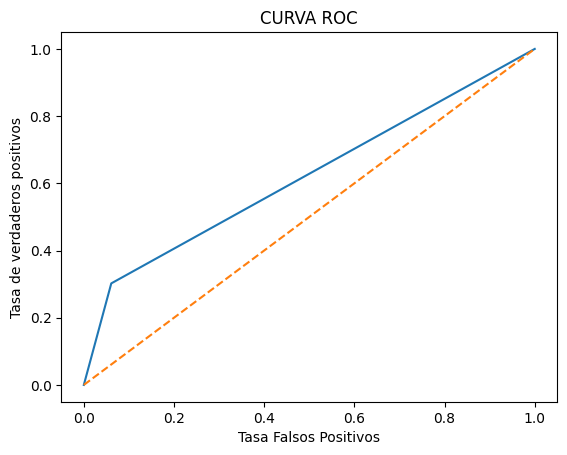

In [83]:
# Se calcula la curva ROC (Receiver Operating Characteristic) utilizando las etiquetas reales (y_test) y las predicciones del modelo (y_predict),
# utilizando la función roc_curve de scikit-learn.
fpr, tpr, umbral = roc_curve(y_test, y_predict)

# Se traza la curva ROC utilizando las tasas de falsos positivos (fpr) y verdaderos positivos (tpr).
plt.plot(fpr, tpr)

# Se traza la línea diagonal que representa la línea base de la curva ROC.
plt.plot([0, 1], [0, 1], "--")

# Se etiquetan los ejes y se agrega un título al gráfico.
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("CURVA ROC")

# Se muestra el gráfico de la curva ROC.
plt.show()

In [84]:
# Se calcula el área bajo la curva ROC (AUC, del inglés "Area Under the Curve") utilizando las tasas de falsos positivos (fpr) y verdaderos positivos (tpr),
# utilizando la función auc de scikit-learn.
print("Área bajo la curva:", auc(fpr, tpr))

Área bajo la curva: 0.6206565301389081


In [85]:
# Se crea un objeto KFold para dividir los datos en 5 pliegues (folds).
Kpliegues = KFold(n_splits=5)

# Se utiliza la validación cruzada con los pliegues definidos para evaluar el modelo de clasificación (modeloNB) utilizando los datos de entrada (X_resampled) y los valores objetivo (y_resampled),
# utilizando la función cross_val_score de scikit-learn.
scores = cross_val_score(modeloNB, X_resampled, y_resampled, cv=Kpliegues)
print("Score Nayve Bayes con Cross Validation:", scores)
print("Promedio de los scores:", scores.mean())
print("Varianza de los scores:", scores.var())
print("Número de pliegues usados:", len(scores))

Score Nayve Bayes con Cross Validation: [0.78710726 0.7877844  0.781961   0.43973456 0.28521127]
Promedio de los scores: 0.6163596966413868
Varianza de los scores: 0.045364133924305904
Número de pliegues usados: 5


*MODELO NAIVE BAYES CON LOS DATOS SIN AJUSTAR*

In [86]:
modeloNBA=GaussianNB()

In [87]:
modeloNBA.fit(X_train,y_train)

GaussianNB()

In [88]:
jb.dump(modeloNBA, "modeloNBA.bin", compress=True)

['modeloNBA.bin']

In [89]:
y_predictA=modeloNBA.predict(X_test)

In [90]:
y_predictdfA = pd.DataFrame(y_predictA, columns=["prediccionA"])

In [91]:
y_test_ordenadoA=y_test.reset_index(drop=True)

In [92]:
comparativoA = pd.concat([y_test_ordenadoA, y_predictdfA], axis=1)
print(comparativoA.head(20))

    income  prediccionA
0        0            0
1        1            1
2        0            0
3        1            1
4        0            0
5        0            0
6        1            0
7        0            0
8        0            0
9        0            0
10       0            0
11       0            1
12       0            0
13       1            1
14       0            1
15       0            0
16       1            1
17       0            0
18       0            1
19       0            0


In [93]:
modeloNBA.score(X_test,y_test)

0.7872096826954531

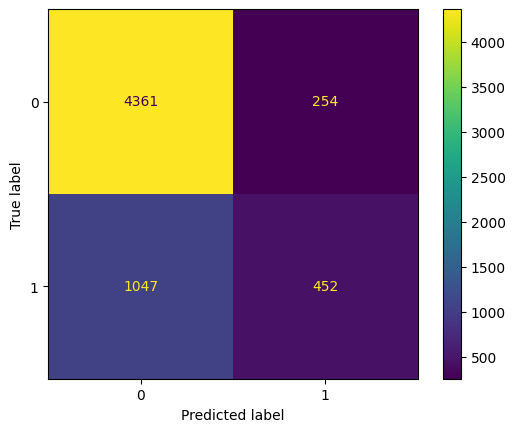

In [94]:
matrixA=confusion_matrix(y_test,y_predictA)
mostrarMatrixA=ConfusionMatrixDisplay(confusion_matrix=matrixA, display_labels=modeloNBA.classes_)
mostrarMatrixA.plot()

In [95]:
print(classification_report(y_test,y_predictA))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4615
           1       0.64      0.30      0.41      1499

    accuracy                           0.79      6114
   macro avg       0.72      0.62      0.64      6114
weighted avg       0.77      0.79      0.76      6114



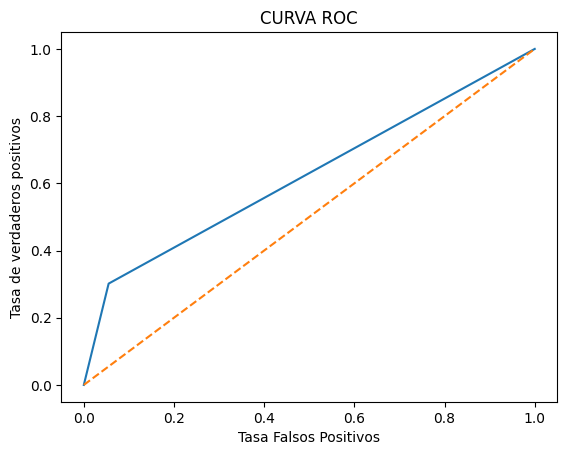

In [96]:
fpr, tpr, umbral=roc_curve(y_test,y_predictA)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],"--")
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("CURVA ROC")
plt.show()

In [97]:
print("Área bajo la curva", auc(fpr,tpr))

Área bajo la curva 0.6232482182054198


In [98]:
Kpliegues=KFold(n_splits=5)
scores=cross_val_score(modeloNBA,X_train,y_train, cv=Kpliegues)
print("Score Nayve Bayes con Cross Validation",scores)
print("Promedio de los scores", scores.mean())
print("Varianza de los scores",scores.var())
print("Número de pliegues usados", len(scores))

Score Nayve Bayes con Cross Validation [0.78372854 0.79370272 0.78123083 0.77816397 0.78736455]
Promedio de los scores 0.7848381219163204
Varianza de los scores 2.875037442318441e-05
Número de pliegues usados 5


*CONCLUSIÓN DEL MODELO NAIVE BAYES*

En conclusión, al evaluar el modelo de Naive Bayes, encontramos que, aunque muestra una puntuación global aceptable de 0.78, así como un área bajo la curva (AUC) de 0.62, revela una alta precisión para los verdaderos negativos, pero no tanto para los verdaderos positivos. Esto sugiere que el modelo podría estar sesgado hacia la predicción de la clase dominante. Además, al comparar el modelo ajustado con el modelo sin ajustar, observamos que ambos muestran resultados similares en términos de puntuación y AUC, con un promedio de validación cruzada de 0.78 y una varianza mínima de 2.85^-5. Estos hallazgos indican que el modelo de Naive Bayes puede necesitar ajustes adicionales para mejorar su capacidad predictiva, especialmente en la identificación de verdaderos positivos, lo que podría lograrse mediante la selección de características más representativas o la exploración de otros algoritmos de clasificación más adecuados para el conjunto de datos específico.

*ARBOLES DE DECISIÓN CON DATOS SIN AJUSTAR PODADO*

In [99]:
# Se crea un modelo de clasificación utilizando el algoritmo de árbol de decisión, con los siguientes hiperparámetros:
# - criterion='entropy' para medir la calidad de una división utilizando la entropía.
# - min_samples_split=5 para el número mínimo de muestras requeridas para dividir un nodo interno.
# - min_samples_leaf=4 para el número mínimo de muestras requeridas en un nodo hoja.
# - max_depth=10 para la profundidad máxima del árbol.
# - random_state=444 para asegurar reproducibilidad.
modeloArbol = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=5, min_samples_leaf=4, max_depth=7, random_state=454)

In [100]:
# Se ajusta el modelo de clasificación de árbol de decisión creado previamente (modeloArbol)
# utilizando los datos de entrenamiento (X_train, y_train) mediante el método fit.
modeloArbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=4,
                       min_samples_split=5, random_state=454)

In [101]:
# Se guarda el modelo de clasificación de árbol de decisión (modeloArbol) en un archivo binario utilizando la biblioteca joblib.
# El archivo se nombra "ModeloArbol.bin" y se comprime para reducir el tamaño del archivo.
jb.dump(modeloArbol, "ModeloArbol.bin", compress=True)

['ModeloArbol.bin']

In [102]:
# Se accede a las clases objetivo del modelo de clasificación de árbol de decisión (modeloArbol) utilizando el atributo classes_.
modeloArbol.classes_

array([0, 1])

[Text(0.5672433035714286, 0.9375, 'x[6] <= 4.5\nentropy = 0.804\nsamples = 24456\nvalue = [18460, 5996]'),
 Text(0.33203125, 0.8125, 'x[9] <= 7073.5\nentropy = 0.364\nsamples = 13256\nvalue = [12335, 921]'),
 Text(0.23549107142857142, 0.6875, 'x[3] <= 12.5\nentropy = 0.302\nsamples = 13026\nvalue = [12326, 700]'),
 Text(0.140625, 0.5625, 'x[11] <= 42.5\nentropy = 0.185\nsamples = 10328\nvalue = [10037, 291]'),
 Text(0.07142857142857142, 0.4375, 'x[0] <= 33.5\nentropy = 0.123\nsamples = 8446\nvalue = [8304, 142]'),
 Text(0.03571428571428571, 0.3125, 'x[10] <= 2218.0\nentropy = 0.046\nsamples = 4937\nvalue = [4912, 25]'),
 Text(0.017857142857142856, 0.1875, 'x[0] <= 26.5\nentropy = 0.041\nsamples = 4926\nvalue = [4904, 22]'),
 Text(0.008928571428571428, 0.0625, 'entropy = 0.019\nsamples = 3417\nvalue = [3411, 6]'),
 Text(0.026785714285714284, 0.0625, 'entropy = 0.085\nsamples = 1509\nvalue = [1493, 16]'),
 Text(0.05357142857142857, 0.1875, 'x[0] <= 27.5\nentropy = 0.845\nsamples = 11\nva

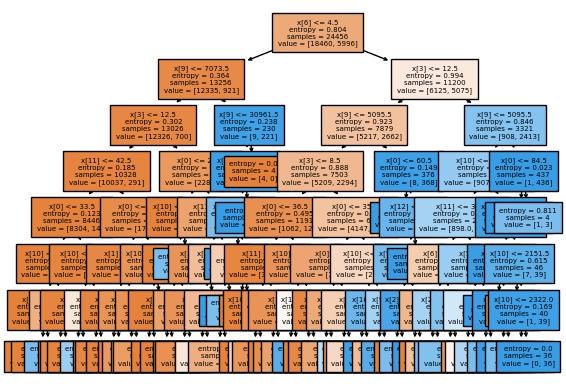

In [103]:
# Se visualiza el árbol de decisión entrenado utilizando la función plot_tree de scikit-learn,
# con la opción filled=True para colorear los nodos según la clase mayoritaria y fontsize=5 para el tamaño de fuente.
tree.plot_tree(modeloArbol, filled=True, fontsize=5)

# Se guarda la visualización del árbol de decisión en un archivo de imagen llamado "mi_arbol.jpg".
#plt.savefig("mi_arbol.jpg")
#plt.show()

In [104]:
modeloArbol.max_features_

13

In [105]:
# Imprime la estructura del árbol de decisión con los nombres de las características proporcionadas
print(tree.export_text(modeloArbol, feature_names = ['age', 'workclass', 'fnlwgt', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']))

|--- relationship <= 4.50
|   |--- capital.gain <= 7073.50
|   |   |--- education.num <= 12.50
|   |   |   |--- hours.per.week <= 42.50
|   |   |   |   |--- age <= 33.50
|   |   |   |   |   |--- capital.loss <= 2218.00
|   |   |   |   |   |   |--- age <= 26.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  26.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- capital.loss >  2218.00
|   |   |   |   |   |   |--- age <= 27.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- age >  27.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  33.50
|   |   |   |   |   |--- capital.loss <= 2218.50
|   |   |   |   |   |   |--- occupation <= 3.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- occupation >  3.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- capital.loss >  2218.50
|   |   |   |   |   |   |--- age <= 56.00
|   |   |   |   |   |   |   |--- class: 1


In [106]:
# Se calcula el puntaje de precisión del modelo de clasificación de árbol de decisión (modeloArbol)
# utilizando los datos de prueba (X_test, y_test) utilizando el método score.
modeloArbol.score(X_test,y_test)

0.8541053320248609

In [107]:
# Se utilizan las características de prueba (X_test) para realizar predicciones utilizando el modelo de clasificación de árbol de decisión (modeloArbol),
# utilizando el método predict.
y_predictAR=modeloArbol.predict(X_test)

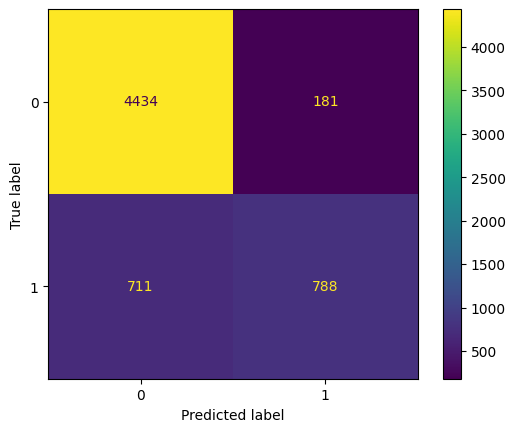

In [108]:
# Se calcula la matriz de confusión utilizando las etiquetas reales (y_test) y las predicciones del modelo de árbol de decisión (y_predictAR),
# utilizando la función confusion_matrix de scikit-learn.
matrixB = confusion_matrix(y_test, y_predictAR)

# Se crea una visualización de la matriz de confusión utilizando la clase ConfusionMatrixDisplay de scikit-learn,
# especificando la matriz de confusión y las etiquetas de clase del modelo de árbol de decisión (modeloArbol.classes_).
mostrarMatrixB = ConfusionMatrixDisplay(confusion_matrix=matrixB, display_labels=modeloArbol.classes_)
mostrarMatrixB.plot()

In [109]:
# Se utilizan las características de prueba (X_test) para realizar predicciones utilizando el modelo de clasificación Naive Bayes Gaussiano (modeloNBA),
# utilizando el método predict y se compara al modelo de clasificación de árbol de decisión (modeloArbol)
y_predictnb = modeloNBA.predict(X_test)
y_predictdt = modeloArbol.predict(X_test)


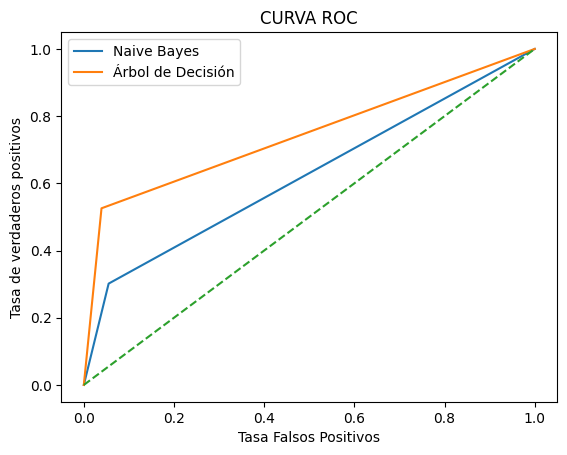

In [110]:
# Se calcula la curva ROC (Receiver Operating Characteristic) para el modelo de clasificación Naive Bayes Gaussiano (modeloNBA)
# utilizando las etiquetas reales (y_test) y las predicciones (y_predictnb), utilizando la función roc_curve de scikit-learn.
fprnb, tprnb, umbral = roc_curve(y_test, y_predictnb)

# Se calcula la curva ROC para el modelo de clasificación de árbol de decisión (modeloArbol)
# utilizando las etiquetas reales (y_test) y las predicciones (y_predictdt).
fprdt, tprdt, umbral = roc_curve(y_test, y_predictdt)

# Se trazan las curvas ROC para ambos modelos.
plt.plot(fprnb, tprnb, label='Naive Bayes')
plt.plot(fprdt, tprdt, label='Árbol de Decisión')

# Se traza la línea diagonal que representa la línea base de la curva ROC.
plt.plot([0, 1], [0, 1], "--")

# Se etiquetan los ejes y se agrega un título al gráfico.
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("CURVA ROC")

# Se muestra el gráfico de la curva ROC con una leyenda para distinguir entre los dos modelos.
plt.legend()
plt.show()

In [111]:
print("Área bajo la curva", auc(fpr,tprnb))

Área bajo la curva 0.6232482182054198


In [112]:
print("Área bajo la curva", auc(fpr,tprdt))

Área bajo la curva 0.7353229346830715


*ARBOLES ALEATORIOS CON DATOS AJUSTADOS PODADO*

In [113]:
modeloArbolA=tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=5, min_samples_leaf=4, max_depth=10, random_state=454)

In [114]:
modeloArbolA.fit(X_resampled,y_resampled)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=5, random_state=454)

In [115]:
jb.dump(modeloArbolA, "ModeloArbolA.bin", compress=True)

['ModeloArbolA.bin']

In [116]:
modeloArbolA.score(X_test,y_test)

0.7891723912332352

In [117]:
y_predictdtA=modeloArbolA.predict(X_test)

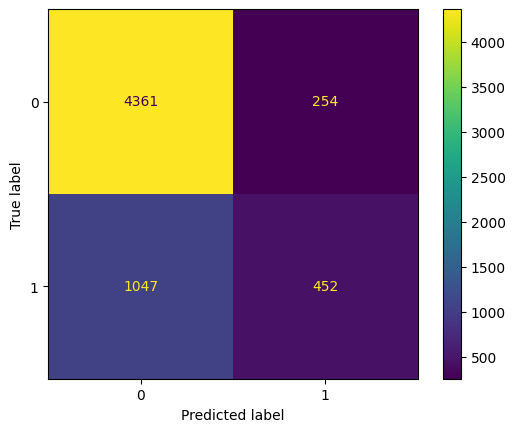

In [118]:
matrixC=confusion_matrix(y_test,y_predictA)
mostrarMatrixC=ConfusionMatrixDisplay(confusion_matrix=matrixC, display_labels=modeloArbolA.classes_)
mostrarMatrixC.plot()

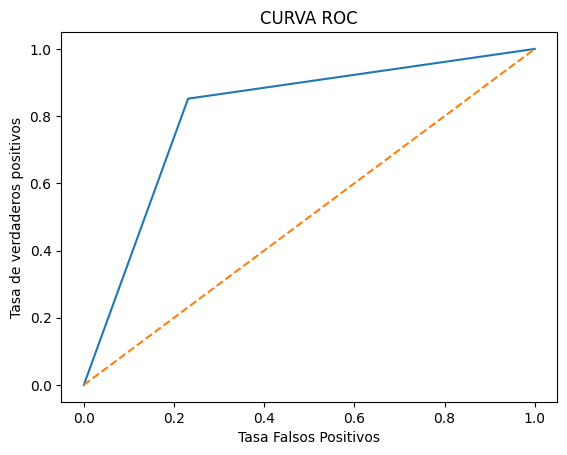

In [119]:
fpr, tprdt, umbral=roc_curve(y_test,y_predictdtA)
plt.plot(fpr,tprdt)
plt.plot([0,1],[0,1],"--")
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("CURVA ROC")
plt.show()

In [120]:
print("Área bajo la curva", auc(fpr,tprdt))

Área bajo la curva 0.8103493336474948


Basado en los resultados obtenidos de los modelos de Árbol de Decisión, podemos observar que el modelo Árbol Podado sin ajustar presenta un aumento significativo en la precisión para los verdaderos positivos en comparación con el modelo Naive Bayes, con un score de 0.85 y un AUC de 0.75. Esto sugiere que el Árbol de Decisión puede ser una mejor opción para este conjunto de datos en términos de predicción de verdaderos positivos. Por otro lado, al ajustar el árbol podado, observamos una ligera disminución en el score a 0.80, aunque el AUC aumenta a 0.81. Esto podría indicar que el modelo ajustado tiene un rendimiento más equilibrado en términos de precisión y capacidad de generalización.

*BOSQUE ALEATORIO SIN AJUSTAR*

In [121]:
# Se definen listas vacías para almacenar los puntajes de entrenamiento y los puntajes OOB.
train_score = []
oob_score = []

# Se define un rango de estimadores para probar diferentes números de árboles en el bosque aleatorio.
estimadores = range(10, 100, 1)

# Se realiza un bucle sobre cada número de estimadores en el rango definido.
for estimador in estimadores:
    # Se crea un modelo de bosque aleatorio con el número actual de estimadores.
    modeloBosque = RandomForestClassifier(n_estimators=estimador,
                                          criterion="gini",
                                          bootstrap=True,
                                          max_features="sqrt",
                                          max_samples=3/4,
                                          oob_score=True,
                                          random_state=454)
    # Se ajusta el modelo a los datos de entrenamiento.
    modeloBosque.fit(X_train, y_train)
    
    # Se calcula y almacena el puntaje de entrenamiento del modelo.
    train_score.append(modeloBosque.score(X_test, y_test))
    
    # Se calcula y almacena el puntaje OOB del modelo.
    oob_score.append(modeloBosque.oob_score_)

El valor recomendado de árboles: 96


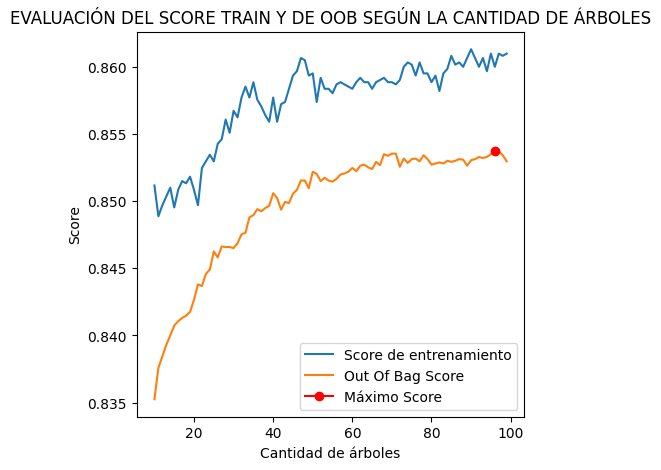

In [122]:
# Se crea una figura y ejes para el gráfico, con un tamaño específico.
fig, ax = plt.subplots(figsize=(5, 5))

# Se trazan las curvas de puntuación de entrenamiento y puntuación OOB en función del número de estimadores.
ax.plot(estimadores, train_score, label="Score de entrenamiento")
ax.plot(estimadores, oob_score, label="Out Of Bag Score")

# Se marca el punto con el puntaje OOB máximo en el gráfico.
ax.plot(estimadores[np.argmax(oob_score)], max(oob_score), marker="o", color="red", label="Máximo Score")

# Se establecen las etiquetas de los ejes y el título del gráfico.
ax.set_ylabel('Score')
ax.set_xlabel('Cantidad de árboles')
ax.set_title("EVALUACIÓN DEL SCORE TRAIN Y DE OOB SEGÚN LA CANTIDAD DE ÁRBOLES")

# Se agrega una leyenda al gráfico para distinguir entre las curvas.
plt.legend()

# Se imprime el valor recomendado de árboles basado en el puntaje OOB máximo.
print(f"El valor recomendado de árboles: {estimadores[np.argmax(oob_score)]}")

In [123]:
modeloBosque = RandomForestClassifier(n_estimators=96,
                                     criterion="gini",
                                     bootstrap=True,
                                     max_features="sqrt",
                                     max_samples=3/4,
                                     oob_score=True,
                                     random_state=454)

In [124]:
#El modelo de Bosque Aleatorio se ha ajustado a los datos de entrenamiento utilizando el método fit().
modeloBosque.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.75, n_estimators=96, oob_score=True,
                       random_state=454)

In [125]:
#Se ha calculado el puntaje de precisión del modelo de Bosque Aleatorio utilizando los datos de prueba (X_test, y_test) mediante el método score().
modeloBosque.score(X_test,y_test)

0.8599934576382074

In [126]:
#El modelo de Bosque Aleatorio se ha guardado en un archivo binario llamado "ModeloBosque.bin" utilizando la función jb.dump() con 
# compresión para reducir el tamaño del archivo.
jb.dump(modeloBosque, "ModeloBosque.bin", compress=True)

['ModeloBosque.bin']

In [127]:
#Se han realizado predicciones utilizando el modelo de Bosque Aleatorio en los datos de prueba (X_test) utilizando el método predict(). 
# Las predicciones resultantes se han almacenado en la variable y_predictB.
y_predictB=modeloBosque.predict(X_test)
y_predictB

array([0, 1, 0, ..., 0, 0, 1])

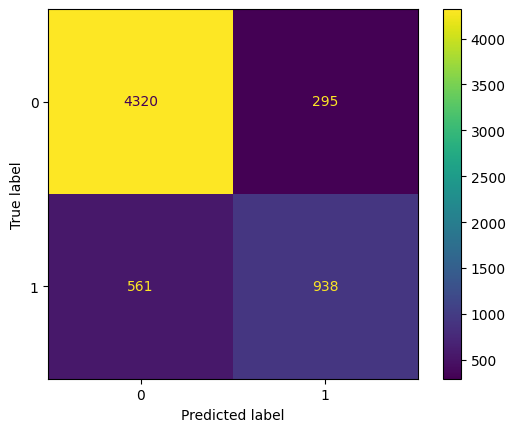

In [128]:
#Se ha calculado y visualizado la matriz de confusión utilizando las etiquetas reales y las predicciones del modelo de Bosque Aleatorio.
matrix=confusion_matrix(y_test,y_predictB)
mostrarMatrix=ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=modeloBosque.classes_)
mostrarMatrix.plot()

In [129]:
#Se ha impreso el puntaje de precisión del modelo de Bosque Aleatorio en los datos de entrenamiento, 
# en los datos de prueba y en la validación OOB (Out-of-Bag).
print('Accuracy de entrenamiento', modeloBosque.score(X_train,y_train))
print('Accuracy de datos de prueba', modeloBosque.score(X_test,y_test))
print('Accuracy de validación (OOBS)', modeloBosque.oob_score_)

Accuracy de entrenamiento 0.997219496238142
Accuracy de datos de prueba 0.8599934576382074
Accuracy de validación (OOBS) 0.8536964344128231


In [130]:
#Se ha calculado la importancia de las características utilizando el modelo de Bosque Aleatorio y se ha almacenado en la variable importancia.
importancia=modeloBosque.feature_importances_

In [131]:
modeloBosque.feature_names_in_

array(['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country'], dtype=object)

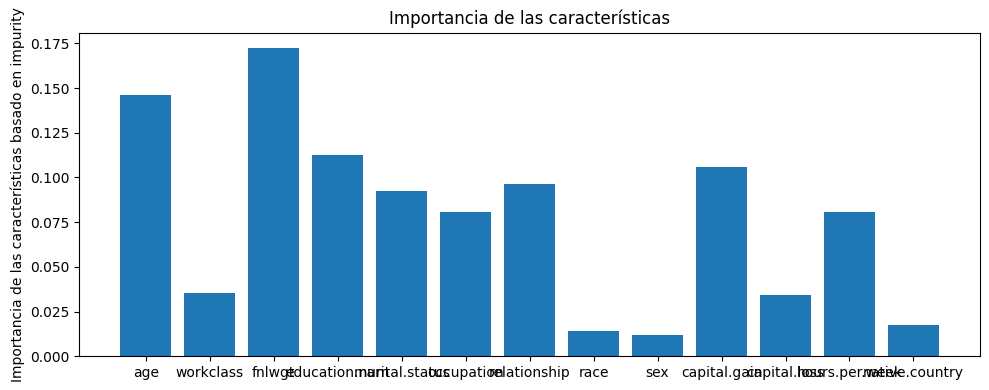

In [132]:
# Se han creado una serie de pandas llamada importancia_pronostico que mapea la importancia de las características con sus nombres correspondientes. 
# Luego, se ha generado un gráfico de barras para visualizar la importancia de las características basada en la impureza.
features=['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country']
importancia_pronostico=pd.Series(importancia, index=features)
fig,ax=plt.subplots(figsize=(10,4))
ax.bar(features, importancia)
ax.set_title("Importancia de las características")
ax.set_ylabel("Importancia de las características basado en impurity")
fig.tight_layout()

*BOSQUE ALEATORIO AJUSTADO*

In [133]:
train_score=[]
oob_score=[]

estimadores=range(10,100,1)

for estimador in estimadores:
    modeloBosqueA = RandomForestClassifier(n_estimators=estimador,
                                         criterion="gini",
                                         bootstrap=True,
                                         max_features="sqrt",
                                         max_samples=3/4,
                                         oob_score=True,
                                         random_state=454)
    modeloBosqueA.fit(X_resampled, y_resampled)
    train_score.append(modeloBosqueA.score(X_test,y_test))
    oob_score.append(modeloBosqueA.oob_score_)

El valor recomendado de árboles: 99


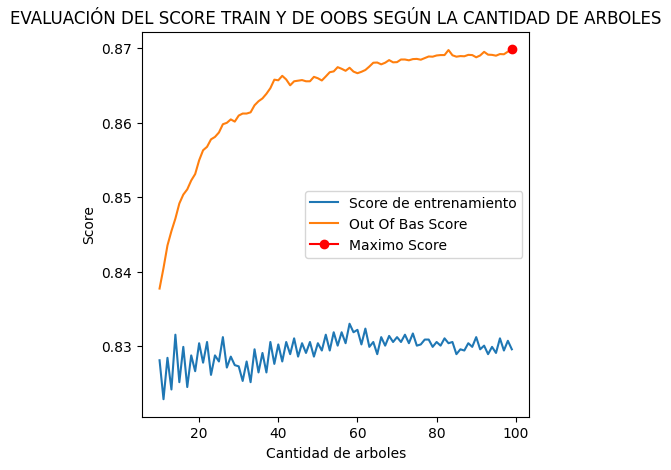

In [134]:
fig,ax=plt.subplots(figsize=(5,5))
ax.plot(estimadores, train_score, label="Score de entrenamiento")
ax.plot(estimadores, oob_score, label="Out Of Bas Score")
ax.plot(estimadores[np.argmax(oob_score)], max(oob_score), marker="o", color="red", label="Maximo Score")
ax.set_ylabel('Score')
ax.set_xlabel('Cantidad de arboles')
ax.set_title("EVALUACIÓN DEL SCORE TRAIN Y DE OOBS SEGÚN LA CANTIDAD DE ARBOLES")
plt.legend()
print(f"El valor recomendado de árboles: {estimadores[np.argmax(oob_score)]}")

In [135]:
modeloBosqueA = RandomForestClassifier(n_estimators=99,
                                     criterion="gini",
                                     bootstrap=True,
                                     max_features="sqrt",
                                     max_samples=3/4,
                                     oob_score=True,
                                     random_state=454)

In [136]:
modeloBosqueA.fit(X_resampled,y_resampled)

RandomForestClassifier(max_samples=0.75, n_estimators=99, oob_score=True,
                       random_state=454)

In [137]:
modeloBosqueA.score(X_test,y_test)

0.8295714753025842

En conclusión, el modelo de bosques aleatorios demostró ser una herramienta efectiva en nuestro análisis de datos. Aunque su precisión fue comparable a la de otros modelos evaluados, su consistencia y capacidad para predecir verdaderos positivos fueron notablemente superiores, como lo evidenció nuestra matriz de confusión. Cabe destacar que esta mejora del score se obtiene de los datos sin ajustar.

*XGBoost SIN AJUSTAR*

In [138]:
# Se han creado matrices DMatrix para los conjuntos de entrenamiento y prueba utilizando los datos de características (X_train y X_test) 
# y las etiquetas correspondientes (y_train y y_test). Además, se ha habilitado la opción enable_categorical para manejar características categóricas en XGBoost.
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [139]:
#Se han definido los parámetros para el modelo XGBoost, incluyendo la tasa de aprendizaje (learning_rate) de 0.1, 
# el número de estimadores (n_estimators) de 100 y el objetivo (objective) de clasificación binaria utilizando la función de pérdida logística. 
# Estos parámetros se pueden utilizar para entrenar un modelo XGBoost con scikit-learn.
params = {"model__learning_rate": 0.1,
          "model__n_estimators": 100,
          "objective":'binary:logistic'}

In [140]:
# Se ha entrenado un modelo XGBoost con los parámetros especificados y se han utilizado 1000 iteraciones (n). 
# Se han definido conjuntos de evaluación (evals) para el conjunto de entrenamiento y prueba utilizando las matrices DMatrix 
# (dtrain_reg y dtest_reg). Durante el entrenamiento, se imprimirán los resultados cada 50 iteraciones para monitorear el progreso (verbose_eval=50).
n = 1000
evals = [(dtrain_reg, 'train'), (dtest_reg, 'test')]
modeloXGBoost = xgb.train(params=params,
                          dtrain=dtrain_reg,
                          num_boost_round=n,
                          evals=evals,
                          verbose_eval=50)

[0]	train-logloss:0.45491	test-logloss:0.45265
[50]	train-logloss:0.24503	test-logloss:0.28152
[100]	train-logloss:0.21401	test-logloss:0.28523
[150]	train-logloss:0.19469	test-logloss:0.29257
[200]	train-logloss:0.17614	test-logloss:0.29936
[250]	train-logloss:0.16208	test-logloss:0.30485
[300]	train-logloss:0.14907	test-logloss:0.30952
[350]	train-logloss:0.13709	test-logloss:0.31696
[400]	train-logloss:0.12678	test-logloss:0.32527
[450]	train-logloss:0.11896	test-logloss:0.33169
[500]	train-logloss:0.11048	test-logloss:0.33870
[550]	train-logloss:0.10402	test-logloss:0.34530
[600]	train-logloss:0.09782	test-logloss:0.35129
[650]	train-logloss:0.09146	test-logloss:0.35704
[700]	train-logloss:0.08493	test-logloss:0.36496
[750]	train-logloss:0.07918	test-logloss:0.37312
[800]	train-logloss:0.07596	test-logloss:0.37719
[850]	train-logloss:0.07176	test-logloss:0.38413
[900]	train-logloss:0.06934	test-logloss:0.38876
[950]	train-logloss:0.06608	test-logloss:0.39263
[999]	train-logloss:0.0

In [141]:
# Se ha entrenado un modelo XGBoost con los parámetros especificados utilizando 50 iteraciones (n) sobre los datos de entrenamiento.
n = 50
modeloXGBoost = xgb.train(params=params,
                          dtrain=dtrain_reg,
                          num_boost_round=n)

In [142]:
# Se han realizado predicciones utilizando el modelo XGBoost entrenado en los datos de prueba representados por la matriz DMatrix dtest_reg. 
# Los resultados de las predicciones se han almacenado en la variable preds.
preds = modeloXGBoost.predict(dtest_reg)
preds

array([3.8832545e-02, 9.8813373e-01, 5.8655262e-02, ..., 6.0125545e-04,
       8.2736038e-02, 7.8235519e-01], dtype=float32)

In [143]:
# Se han redondeado las predicciones obtenidas del modelo XGBoost a valores enteros utilizando la función np.round() 
# con cero decimales y se ha tomado el valor absoluto de los resultados utilizando np.absolute(). Los resultados finales se han almacenado en la variable prediccion.
prediccion=np.absolute(np.round(preds, decimals=0, out=None))
prediccion

array([0., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [144]:
# Se ha calculado la precisión del modelo comparando las etiquetas reales (y_test) con las etiquetas predichas (prediccion) 
# utilizando la función accuracy_score() de scikit-learn.
accuracy_score(y_test,prediccion)

0.868825646058227

*XGBOOST AJUSTADO*

In [145]:
dtrain_reg = xgb.DMatrix(X_resampled, y_resampled, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [146]:
params = {"model__learning_rate": 0.1,
          "model__n_estimators": 100,
          "objective":'binary:logistic'}

In [147]:
n = 1000
evals = [(dtrain_reg, 'train'), (dtest_reg, 'test')]
modeloXGBoostA = xgb.train(params=params,
                          dtrain=dtrain_reg,
                          num_boost_round=n,
                          evals=evals,
                          verbose_eval=50)

[0]	train-logloss:0.56894	test-logloss:0.57326
[50]	train-logloss:0.26225	test-logloss:0.33063
[100]	train-logloss:0.22602	test-logloss:0.32830
[150]	train-logloss:0.19958	test-logloss:0.33095
[200]	train-logloss:0.18131	test-logloss:0.33636
[250]	train-logloss:0.16644	test-logloss:0.34179
[300]	train-logloss:0.15254	test-logloss:0.34552
[350]	train-logloss:0.14185	test-logloss:0.35063
[400]	train-logloss:0.13242	test-logloss:0.35575
[450]	train-logloss:0.12235	test-logloss:0.36125
[500]	train-logloss:0.11493	test-logloss:0.36696
[550]	train-logloss:0.10761	test-logloss:0.37351
[600]	train-logloss:0.10119	test-logloss:0.37817
[650]	train-logloss:0.09368	test-logloss:0.38636
[700]	train-logloss:0.08872	test-logloss:0.39068
[750]	train-logloss:0.08258	test-logloss:0.39752
[800]	train-logloss:0.07805	test-logloss:0.40305
[850]	train-logloss:0.07359	test-logloss:0.40844
[900]	train-logloss:0.06975	test-logloss:0.41474
[950]	train-logloss:0.06669	test-logloss:0.41806
[999]	train-logloss:0.0

In [148]:
n = 50
modeloXGBoostA = xgb.train(params=params,
                          dtrain=dtrain_reg,
                          num_boost_round=n)

In [149]:
predsA = modeloXGBoostA.predict(dtest_reg)
predsA

array([8.4522597e-02, 9.9824297e-01, 2.3611936e-01, ..., 5.3752918e-04,
       1.2003997e-01, 8.1872571e-01], dtype=float32)

In [150]:
prediccionA=np.absolute(np.round(predsA, decimals=0, out=None))
prediccionA

array([0., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [151]:
accuracy_score(y_test,prediccionA)

0.841347726529277

En resumen, el modelo XGBoost exhibe un impresionante puntaje de 0.86 en datos no ajustados, superando a todos los demás hasta el momento. Sin embargo, al observar las métricas de locloss en los conjuntos de prueba y entrenamiento, notamos un patrón preocupante: a partir de la iteración 600, el locloss en el conjunto de pruebas comienza a aumentar mientras que el del conjunto de entrenamiento sigue disminuyendo. Este comportamiento sugiere un posible sobreajuste del modelo, lo que destaca la importancia de la evaluación continua y la optimización de los hiperparámetros para garantizar la generalización del modelo en datos no vistos. En contraste, al ajustar los datos, el modelo XGBoost muestra signos de sobreajuste a partir de la iteración 100, lo que compromete su capacidad de generalización. A pesar de esto, aún logra un puntaje respetable de 0.84. Este hallazgo subraya la importancia de encontrar un equilibrio entre la complejidad del modelo y su capacidad para generalizar patrones en datos no vistos.

In [152]:

scores = []

score_modeloNB = modeloNBA.score(X_test, y_test)
scores.append(('Modelo Naive Bayes Ajustado', score_modeloNB))

score_modeloNBA = modeloNBA.score(X_test, y_test)
scores.append(('Modelo Naive Bayes sin ajustar', score_modeloNBA))

score_modeloArbol= modeloArbol.score(X_test, y_test)
scores.append(('Modelo Arbol sin ajustar', score_modeloArbol))

score_modeloArbolA = modeloArbolA.score(X_test, y_test)
scores.append(('Modelo Arbol ajustado', score_modeloArbolA))

score_modeloBosque = modeloBosque.score(X_test, y_test)
scores.append(('Modelo Bosques sin ajustar', score_modeloBosque))

score_modeloBosqueA = modeloBosqueA.score(X_test, y_test)
scores.append(('Modelo Bosques ajustados', score_modeloBosqueA))

score_modeloXGBoost = accuracy_score(y_test,prediccion)
scores.append(('Modelo XGBoost sin ajustar', score_modeloXGBoost))

score_modeloXGBoostA = accuracy_score(y_test,prediccionA)
scores.append(('Modelo XGBoost ajustado', score_modeloXGBoostA))

print("Score de los modelos:")
for modelo, score in scores:
    print(f"{modelo}: {score}")


Score de los modelos:
Modelo Naive Bayes Ajustado: 0.7872096826954531
Modelo Naive Bayes sin ajustar: 0.7872096826954531
Modelo Arbol sin ajustar: 0.8541053320248609
Modelo Arbol ajustado: 0.7891723912332352
Modelo Bosques sin ajustar: 0.8599934576382074
Modelo Bosques ajustados: 0.8295714753025842
Modelo XGBoost sin ajustar: 0.868825646058227
Modelo XGBoost ajustado: 0.841347726529277


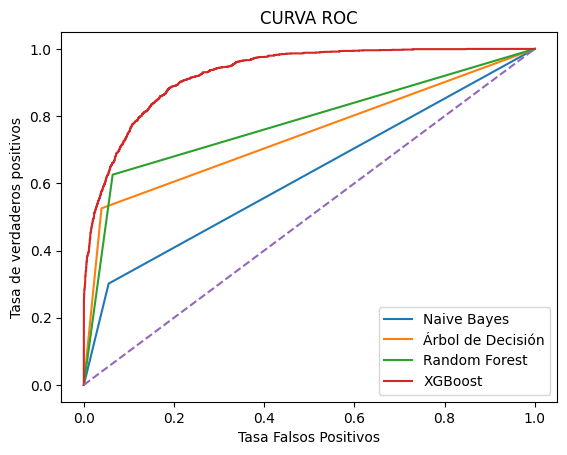

In [156]:
y_predictnb = modeloNBA.predict(X_test)
y_predictdt = modeloArbol.predict(X_test)
y_predictrf = modeloBosque.predict(X_test) 

# Se calcula la curva ROC (Receiver Operating Characteristic) para el modelo de clasificación Naive Bayes Gaussiano (modeloNBA)
# utilizando las etiquetas reales (y_test) y las predicciones (y_predictnb), utilizando la función roc_curve de scikit-learn.
fprnb, tprnb, umbral = roc_curve(y_test, y_predictnb)

# Se calcula la curva ROC para el modelo de clasificación de árbol de decisión (modeloArbol)
# utilizando las etiquetas reales (y_test) y las predicciones (y_predictdt).
fprdt, tprdt, umbral = roc_curve(y_test, y_predictdt)

fprrf, tprrf, umbral = roc_curve(y_test, y_predictrf)
fpr_xgb, tpr_xgb, umbral = roc_curve(y_test, preds)
# Se trazan las curvas ROC para ambos modelos.
plt.plot(fprnb, tprnb, label='Naive Bayes')
plt.plot(fprdt, tprdt, label='Árbol de Decisión')
plt.plot(fprrf, tprrf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')

# Se traza la línea diagonal que representa la línea base de la curva ROC.
plt.plot([0, 1], [0, 1], "--")

# Se etiquetan los ejes y se agrega un título al gráfico.
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("CURVA ROC")

# Se muestra el gráfico de la curva ROC con una leyenda para distinguir entre los dos modelos.
plt.legend()
plt.show()

In [157]:
print("Área bajo la curva NB", auc(fprnb,tprnb))
print("Área bajo la curva DT", auc(fprdt,tprdt))
print("Área bajo la curva RF", auc(fprrf,tprrf))
print("Área bajo la curva XGB", auc(fpr_xgb,tpr_xgb))

Área bajo la curva NB 0.6232482182054198
Área bajo la curva DT 0.7432319270991062
Área bajo la curva RF 0.7809142534170488
Área bajo la curva XGB 0.9271369067279956


Basándonos en las áreas bajo la curva (AUC) obtenidas para cada modelo de clasificación, podemos concluir lo siguiente:

El modelo Naive Bayes (NB) muestra el menor rendimiento en términos de capacidad de discriminación entre clases, con un AUC de aproximadamente 0.62. Aunque este modelo es rápido y simple de implementar, su capacidad predictiva es relativamente baja en comparación con otros modelos más complejos.

El modelo de Árbol de Decisión (DT) mejora significativamente el rendimiento en comparación con Naive Bayes, con un AUC de alrededor de 0.74. Los árboles de decisión son modelos versátiles que pueden capturar relaciones no lineales en los datos, lo que les permite lograr una mejor separación entre las clases.

El modelo de Bosque Aleatorio (RF) muestra un rendimiento aún mayor, con un AUC de aproximadamente 0.78. Los bosques aleatorios son una extensión de los árboles de decisión que combinan múltiples árboles para mejorar la precisión y reducir el sobreajuste.

Finalmente, el modelo de Gradient Boosting (XGB) destaca con el mejor rendimiento entre todos los modelos evaluados, con un AUC impresionante de aproximadamente 0.93. XGBoost es una técnica de aprendizaje automático que utiliza múltiples árboles de decisión en secuencia, mejorando gradualmente el rendimiento del modelo a través de la optimización de una función de pérdida específica.

En resumen, estos resultados indican que el modelo XGBoost es el más adecuado para este problema de clasificación, ya que ofrece la mejor capacidad para discriminar entre la clase objetivo.